## Deep Learning Techniques to Classify Sickle Cells

### Import Libraries

In [2]:
import numpy as np
import pandas as pd 
import shutil
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import time
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
!pip install timm
import timm
import argparse
import json
from collections import defaultdict
from datetime import datetime
import copy
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_curve, auc, roc_auc_score)

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [3]:
raw_data_dir = "/kaggle/input/blood-films-4th/blood_films_4th"

def count_raw_images_per_class(raw_dir):
    counts = {}
    for class_name in os.listdir(raw_dir):
        class_path = os.path.join(raw_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        num_images = len([f for f in os.listdir(class_path) 
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        counts[class_name] = num_images
    return counts

raw_counts = count_raw_images_per_class(raw_data_dir)

print("Raw dataset image counts per class:")
for cls, num in raw_counts.items():
    print(f"{cls}: {num} images")

print(f"\nTotal images: {sum(raw_counts.values())}")

Raw dataset image counts per class:
unlabelled: 14 images
pos: 1418 images
neg: 568 images

Total images: 2000


In [7]:
# Input: balanced dataset with equal number of images per class
balanced_output = "/kaggle/input/blood-films-4th/blood_films_4th"
final_output = "/kaggle/working/dataset_split"

# Train/Val/Test ratios
train_ratio = 0.7
val_ratio   = 0.15
test_ratio  = 0.15

def split_dataset(input_dir, output_dir, train_ratio, val_ratio, test_ratio):
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir, exist_ok=True)

    # Create subfolders
    for split in ["train", "val", "test"]:
        os.makedirs(os.path.join(output_dir, split), exist_ok=True)

    for class_name in os.listdir(input_dir):
        # 🚫 Skip unlabelled folder
        if class_name.lower() in ["unlabelled", "unlabeled", "unknown"]:
            print(f"Skipping folder: {class_name}")
            continue
        
        class_path = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg','.jpeg','.png'))]
        random.shuffle(images)

        n_total = len(images)
        n_train = int(n_total * train_ratio)
        n_val   = int(n_total * val_ratio)
        n_test  = n_total - n_train - n_val

        splits = {
            "train": images[:n_train],
            "val":   images[n_train:n_train+n_val],
            "test":  images[n_train+n_val:]
        }

        for split, split_imgs in splits.items():
            split_dir = os.path.join(output_dir, split, class_name)
            os.makedirs(split_dir, exist_ok=True)
            for img in split_imgs:
                shutil.copy2(os.path.join(class_path, img), os.path.join(split_dir, img))

    print(f"✅ Dataset split completed! Train/Val/Test saved in {output_dir}")

# Run
split_dataset(balanced_output, final_output, train_ratio, val_ratio, test_ratio)

Skipping folder: unlabelled
✅ Dataset split completed! Train/Val/Test saved in /kaggle/working/dataset_split


In [3]:
dataset_dir = "/kaggle/working/dataset_split"  # where train/val/test are stored

def count_images(root_dir):
    summary = {}
    for split in ["train", "val", "test"]:
        split_dir = os.path.join(root_dir, split)
        summary[split] = {}
        for class_name in os.listdir(split_dir):
            class_path = os.path.join(split_dir, class_name)
            if not os.path.isdir(class_path):
                continue
            count = len([f for f in os.listdir(class_path) 
                         if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            summary[split][class_name] = count
    return summary

# Run
counts = count_images(dataset_dir)

for split, classes in counts.items():
    print(f"\n{split.upper()}:")
    for cls, cnt in classes.items():
        print(f"  {cls}: {cnt} images")


TRAIN:
  pos: 992 images
  neg: 397 images

VAL:
  pos: 212 images
  neg: 85 images

TEST:
  pos: 214 images
  neg: 86 images


In [23]:
# ------------- Config / hyperparams -------------
DATA_DIR = "dataset_split"   # expects dataset_split/train/<class> etc
CHECKPOINT_DIR = "checkpoints"
OUTPUT_DIR = "outputs"
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_WORKERS = 4
LR = 1e-4
WEIGHT_DECAY = 1e-4
EPOCHS = 100
EARLY_STOPPING_PATIENCE = 10
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create dirs
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [5]:
# ------------- Utils -------------
def makedirs(path):
    os.makedirs(path, exist_ok=True)

def save_json(obj, path):
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)

In [12]:
# ------------- Dataloader -------------
def get_dataloaders(data_dir, img_size=IMG_SIZE, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.2,0.2,0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ])
    val_test_transforms = transforms.Compose([
        transforms.Resize(int(img_size*1.1)),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ])

    train_ds = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transforms)
    val_ds   = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=val_test_transforms)
    test_ds  = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=val_test_transforms)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    class_names = train_ds.classes
    return train_loader, val_loader, test_loader, class_names

In [13]:
# ------------- Attention (SE block) -------------
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, c, _, _ = x.size()
        w = self.fc(x).view(b, c, 1, 1)
        return x * w

In [14]:
def add_se_to_model(model, target_layer_name=None):
    """
    Attach SE block to CNN backbones:
    - ResNet
    - MobileNetV2
    - VGG
    - DenseNet
    - EfficientNetB0 (torchvision & timm)
    - InceptionV3
    """
    # -------- RESNET (ResNet50 etc) -----------
    if hasattr(model, "layer4"):
        orig = model.layer4
        last_conv_channels = None
        for m in reversed(list(orig.modules())):
            if isinstance(m, nn.Conv2d):
                last_conv_channels = m.out_channels
                break
        if last_conv_channels is not None:
            se = SEBlock(last_conv_channels)
            model.layer4 = nn.Sequential(orig, se)
        return model

    # -------- MOBILENETV2 ----------
    if hasattr(model, "features") and "MobileNetV2" in str(type(model)):
        last_conv_channels = None
        for m in reversed(list(model.features.modules())):
            if isinstance(m, nn.Conv2d):
                last_conv_channels = m.out_channels
                break
        if last_conv_channels:
            model.features = nn.Sequential(model.features, SEBlock(last_conv_channels))
        return model

    # -------- VGG ----------
    if "VGG" in str(type(model)):
        last_conv_channels = None
        for m in reversed(list(model.features.modules())):
            if isinstance(m, nn.Conv2d):
                last_conv_channels = m.out_channels
                break
        if last_conv_channels:
            model.features = nn.Sequential(model.features, SEBlock(last_conv_channels))
        return model

    # -------- DENSENET ----------
    if "DenseNet" in str(type(model)):
        # last module in Densenet.features is a Conv2d
        last_conv = None
        for m in reversed(list(model.features.modules())):
            if isinstance(m, nn.Conv2d):
                last_conv = m.out_channels
                break
        if last_conv:
            model.features = nn.Sequential(model.features, SEBlock(last_conv))
        return model

    # -------- EFFICIENTNET (torchvision) ----------
    if "EfficientNet" in str(type(model)):  # covers B0 & others
        # last conv layer is in features[-1]
        last_conv = None
        for m in reversed(list(model.features.modules())):
            if isinstance(m, nn.Conv2d):
                last_conv = m.out_channels
                break
        if last_conv:
            model.features = nn.Sequential(model.features, SEBlock(last_conv))
        return model

    # -------- EFFICIENTNET / SWIN via TIMM ----------
    if hasattr(model, "conv_head") and hasattr(model, "blocks"):
        if isinstance(model.conv_head, nn.Conv2d):
            out_ch = model.conv_head.out_channels
            model.se_post = SEBlock(out_ch)

            # Monkey-patch forward
            old_forward = model.forward

            def forward_with_se(x):
                x = old_forward(x)
                x = model.se_post(x)
                return x

            model.forward = forward_with_se
        return model

    # -------- INCEPTION-V3 ----------
    if "Inception3" in str(type(model)):
        # last conv usually in Mixed_7c
        last_conv = None
        for m in reversed(list(model.Mixed_7c.modules())):
            if isinstance(m, nn.Conv2d):
                last_conv = m.out_channels
                break
        if last_conv:
            model.Mixed_7c = nn.Sequential(model.Mixed_7c, SEBlock(last_conv))
        return model

    return model  # fallback

In [15]:
def build_model(name, num_classes, pretrained=True, use_se=True):
    name = name.lower()

    # ------------------ RESNET18 ------------------
    if name == "resnet18":
        model = models.resnet18(pretrained=pretrained)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        if use_se:
            model = add_se_to_model(model)
        return model

    # ------------------ RESNET50 ------------------
    if name == "resnet50":
        model = models.resnet50(pretrained=pretrained)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        if use_se:
            model = add_se_to_model(model)
        return model

    # ------------------ VGG16 ------------------
    if name == "vgg16":
        model = models.vgg16(pretrained=pretrained)
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
        if use_se:
            model = add_se_to_model(model)
        return model

    # ------------------ MOBILENETV2 ------------------
    if name in ["mobilenet_v2", "mobilenetv2"]:
        model = models.mobilenet_v2(pretrained=pretrained)
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
        if use_se:
            model = add_se_to_model(model)
        return model

    # ------------------ DENSENET121 ------------------
    if name == "densenet121":
        model = models.densenet121(pretrained=pretrained)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
        if use_se:
            model = add_se_to_model(model)
        return model

    # ------------------ EFFICIENTNET-B0 (Torchvision) ------------------
    if name in ["efficientnet_b0", "efficientnet"]:
        try:
            model = models.efficientnet_b0(pretrained=pretrained)
            model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
            if use_se:
                model = add_se_to_model(model)
            return model
        except:
            # Fallback: timm
            model = timm.create_model("efficientnet_b0", pretrained=pretrained, num_classes=num_classes)
            return model

    # ------------------ INCEPTION-V3 ------------------
    if name in ["inception_v3", "inception"]:
        model = models.inception_v3(pretrained=pretrained, aux_logits=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        if use_se:
            model = add_se_to_model(model)
        return model

    # ------------------ SWIN TRANSFORMER ------------------
    if name in ["swin_tiny", "swin"]:
        model = timm.create_model("swin_tiny_patch4_window7_224", pretrained=pretrained, num_classes=num_classes)
        return model

    # ------------------ UNKNOWN ------------------
    raise ValueError(f"Unknown model {name}")

In [16]:

# ------------- Training / evaluation helpers -------------
def save_checkpoint(state, filename):
    torch.save(state, filename)

class EarlyStopping:
    def __init__(self, patience=EARLY_STOPPING_PATIENCE, minimize=False):
        self.patience = patience
        self.counter = 0
        self.best = None
        self.minimize = minimize

    def step(self, metric):
        if self.best is None:
            self.best = metric
            return False
        improved = (metric < self.best) if self.minimize else (metric > self.best)
        if improved:
            self.best = metric
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def compute_metrics_all(y_true, y_pred, y_score, average="macro"):
    # y_score: N x C probability scores for ROC/AUC
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=average, zero_division=0)
    rec = recall_score(y_true, y_pred, average=average, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=average, zero_division=0)

    # multiclass ROC AUC (one-vs-rest)
    try:
        roc_auc = roc_auc_score(
            np.eye(len(np.unique(y_true)))[y_true],   # one-hot true
            y_score, average="macro", multi_class="ovr"
        )
    except Exception:
        roc_auc = None

    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": roc_auc}

def evaluate(model, loader, device, num_classes):
    model.eval()
    ys, ys_pred, ys_prob = [], [], []
    soft = nn.Softmax(dim=1)
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            probs = soft(logits).cpu().numpy()
            preds = np.argmax(probs, axis=1)
            ys.extend(yb.cpu().numpy().tolist())
            ys_pred.extend(preds.tolist())
            ys_prob.extend(probs.tolist())
    ys = np.array(ys)
    ys_pred = np.array(ys_pred)
    ys_prob = np.array(ys_prob)
    metrics = compute_metrics_all(ys, ys_pred, ys_prob)
    cm = confusion_matrix(ys, ys_pred)
    return metrics, cm, ys, ys_pred, ys_prob

In [17]:

# ------------- Plotting ROC -------------
def plot_roc_curves(y_true, y_score, class_names, out_path):
    # y_true: array of labels, y_score: N x C scores
    n_classes = len(class_names)
    y_true_oh = np.eye(n_classes)[y_true]
    plt.figure(figsize=(8, 8))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_oh[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")
    plt.plot([0,1], [0,1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (one-vs-rest)")
    plt.legend(loc="lower right")
    plt.savefig(out_path)
    plt.close()
    print("Saved ROC plot to", out_path)

In [18]:
# ------------- Grad-CAM implementation -------------
class GradCAM:
    def __init__(self, model, target_layer):
        """
        model: nn.Module
        target_layer: the layer (module) from which to take gradients/activations (e.g., model.layer4[-1])
        """
        self.model = model
        self.model.eval()
        self.target_layer = target_layer

        self.activations = None
        self.gradients = None

        # register hooks
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    def __call__(self, input_tensor, class_idx=None):
        """
        input_tensor: tensor of shape (1, C, H, W)
        class_idx: index for which to compute Grad-CAM. If None, uses predicted class.
        Returns: heatmap numpy (H,W)
        """
        self.model.zero_grad()
        out = self.model(input_tensor)
        if class_idx is None:
            class_idx = out.argmax(dim=1).item()
        score = out[:, class_idx]
        score.backward(retain_graph=True)

        grads = self.gradients[0]  # C x H x W
        activations = self.activations[0]  # C x H x W

        weights = grads.mean(dim=(1,2))  # C
        cam = (weights[:, None, None] * activations).sum(dim=0).cpu().numpy()
        cam = np.maximum(cam, 0)
        cam = cam - cam.min()
        if cam.max() != 0:
            cam = cam / cam.max()
        cam = np.uint8(255 * cam)
        return cam

def save_gradcam_overlay(orig_pil, cam, out_path, alpha=0.4):
    import cv2
    orig = np.array(orig_pil.resize((cam.shape[1], cam.shape[0])))
    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(heatmap, alpha, orig[..., :3], 1-alpha, 0)
    Image.fromarray(overlay).save(out_path)

In [19]:
# ------------- Save Grad-CAM examples -------------
def find_target_layer_for_gradcam(model):
    # heuristics to find a conv layer for Grad-CAM (ResNet layer4[-1], or model.features[-1])
    if hasattr(model, "layer4"):
        # return the last block's last conv
        return model.layer4[-1]
    if hasattr(model, "features"):
        return model.features[-1]
    # as fallback, try to find last nn.Conv2d in model
    last = None
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            last = m
    return last

import random
import os

def save_some_gradcam_examples(model, loader, class_names, device, out_dir, n_examples=5):
    os.makedirs(out_dir, exist_ok=True)
    model.to(device).eval()
    target_layer = find_target_layer_for_gradcam(model)
    if target_layer is None:
        print("No conv target found for GradCAM")
        return
    
    gradcam = GradCAM(model, target_layer)
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    
    # --- Collect all images first so we can randomly choose from them ---
    all_images = []
    for xb, yb in loader:
        for i in range(xb.size(0)):
            all_images.append((xb[i], yb[i]))
    print(f"Total images available for Grad-CAM: {len(all_images)}")
    
    # --- Randomly pick n_examples ---
    selected_samples = random.sample(all_images, min(n_examples, len(all_images)))
    
    for idx, (img_tensor, label) in enumerate(selected_samples):
        print(f"Grad-CAM for sample {idx}: class={class_names[label]}, label={label}")
        img_t = img_tensor.unsqueeze(0).to(device)
        pil_img = transforms.ToPILImage()(inv_normalize(img_tensor).cpu())
        cam = gradcam(img_t)
        
        out_path = os.path.join(out_dir, f"gradcam_{idx}_gt{class_names[label]}.png")
        save_gradcam_overlay(pil_img, cam, out_path)

In [27]:
# ------------- Training loop -------------
def train_and_evaluate(model_name, dataloaders, class_names, device, output_root, epochs=EPOCHS,
                       lr=LR, weight_decay=WEIGHT_DECAY, resume_checkpoint=None):
    train_loader, val_loader, test_loader = dataloaders
    num_classes = len(class_names)
    model = build_model(model_name, num_classes=num_classes, pretrained=True, use_se=True)
    model = model.to(device)

    # optimizer & scheduler
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

    start_epoch = 0
    history = defaultdict(list)
    best_val_f1 = -1.0

    checkpoint_path = os.path.join(CHECKPOINT_DIR, f"{model_name}_best.pth")
    resume_path = resume_checkpoint or None
    if resume_path and os.path.exists(resume_path):
        print(f"Resuming from {resume_path}")
        cp = torch.load(resume_path, map_location=device, weights_only=False)
        model.load_state_dict(cp['model_state'])
        optimizer.load_state_dict(cp['opt_state'])
        start_epoch = cp.get('epoch', 0) + 1
        history = cp.get('history', defaultdict(list))
        best_val_f1 = cp.get('best_val_f1', best_val_f1)

    early_stopper = EarlyStopping(patience=EARLY_STOPPING_PATIENCE)

    soft = nn.Softmax(dim=1)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(start_epoch, epochs):
        print(f"\n=== {model_name} Epoch {epoch+1}/{epochs} ===")
        # train
        model.train()
        running_loss = 0.0
        all_preds = []
        all_targets = []
        for xb, yb in train_loader:
            xb = xb.to(device); yb = yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds.tolist())
            all_targets.extend(yb.cpu().numpy().tolist())

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = accuracy_score(all_targets, all_preds)
        epoch_prec = precision_score(all_targets, all_preds, average="macro", zero_division=0)
        epoch_rec = recall_score(all_targets, all_preds, average="macro", zero_division=0)
        epoch_f1 = f1_score(all_targets, all_preds, average="macro", zero_division=0)

        print(f"Train loss: {epoch_loss:.4f} acc: {epoch_acc:.4f} f1: {epoch_f1:.4f}")
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        history['train_f1'].append(epoch_f1)

        # val
        val_metrics, val_cm, _, _, _ = evaluate(model, val_loader, device, num_classes)
        print(f"Val metrics: acc {val_metrics['accuracy']:.4f} f1 {val_metrics['f1']:.4f} roc_auc {val_metrics['roc_auc']}")
        history['val_acc'].append(val_metrics['accuracy'])
        history['val_f1'].append(val_metrics['f1'])
        history['val_metrics'].append(val_metrics)

        # scheduler step on val f1
        if val_metrics['f1'] is not None:
            scheduler.step(val_metrics['f1'])

        # checkpoint
        is_best = val_metrics['f1'] is not None and val_metrics['f1'] > best_val_f1
        if is_best:
            best_val_f1 = val_metrics['f1']
            save_checkpoint({
                'epoch': epoch,
                'model_state': model.state_dict(),
                'opt_state': optimizer.state_dict(),
                'best_val_f1': best_val_f1,
                'history': history,
                'class_names': class_names
            }, checkpoint_path)
            print(f"Saved best checkpoint to {checkpoint_path}")

        # # periodic checkpoint (so we can resume)
        # periodic_path = os.path.join(CHECKPOINT_DIR, f"{model_name}_epoch_{epoch}.pth")
        # save_checkpoint({
        #     'epoch': epoch,
        #     'model_state': model.state_dict(),
        #     'opt_state': optimizer.state_dict(),
        #     'best_val_f1': best_val_f1,
        #     'history': history,
        #     'class_names': class_names
        # }, periodic_path)

        # early stopping
        stop = early_stopper.step(val_metrics['f1'] if val_metrics['f1'] is not None else 0)
        if stop:
            print("Early stopping triggered.")
            break

    # After training -> final eval on train/val/test and save results
    print("Evaluating final models on train/val/test...")
    metrics_train, cm_train, y_train, y_train_pred, y_train_prob = evaluate(model, train_loader, device, num_classes)
    metrics_val, cm_val, y_val, y_val_pred, y_val_prob = evaluate(model, val_loader, device, num_classes)
    metrics_test, cm_test, y_test, y_test_pred, y_test_prob = evaluate(model, test_loader, device, num_classes)

    # save model final
    final_path = os.path.join(OUTPUT_DIR, f"{model_name}_final.pth")
    torch.save({'model_state': model.state_dict(),
                'class_names': class_names}, final_path)
    print(f"Saved final model to {final_path}")

    # save metrics and confusion matrices and histories
    timeid = datetime.now().strftime("%Y%m%d_%H%M%S")
    out = {
        "model_name": model_name,
        "history": history,
        "metrics_train": metrics_train,
        "metrics_val": metrics_val,
        "metrics_test": metrics_test,
        "cm_train": cm_train.tolist() if isinstance(cm_train, np.ndarray) else cm_train,
        "cm_val": cm_val.tolist(),
        "cm_test": cm_test.tolist(),
        "class_names": class_names
    }
    save_json(out, os.path.join(OUTPUT_DIR, f"{model_name}_results_{timeid}.json"))

    # # Plot ROC (one-vs-rest)
    # try:
    #     plot_roc_curves(y_test, y_test_prob, class_names, os.path.join(OUTPUT_DIR, f"{model_name}_roc_{timeid}.png"))
    # except Exception as e:
    #     print("Failed to plot ROC:", e)

    # # Save a few Grad-CAM examples from test set
    # try:
    #     save_some_gradcam_examples(model, test_loader, class_names, device, os.path.join(OUTPUT_DIR, f"{model_name}_gradcam"))
    # except Exception as e:
    #     print("Failed to run Grad-CAM:", e)

    print("Done training and evaluation for", model_name)
    return out

In [24]:
def main(model_name="resnet18", resume=None, epochs=EPOCHS, batch_size=BATCH_SIZE):
    global BATCH_SIZE
    BATCH_SIZE = batch_size

    dataloaders = get_dataloaders(DATA_DIR, img_size=IMG_SIZE, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
    train_loader, val_loader, test_loader, class_names = dataloaders

    if model_name == "all":
        models_to_run = [
            "resnet18",
            "resnet50",
            "vgg16",
            "mobilenet_v2",
            "efficientnet_b0",
            "swin_tiny",
            "densenet121",
            "inception_v3"
        ]
    else:
        models_to_run = [model_name]

    for mname in models_to_run:
        print(f"\n*** Running: {mname} ***")
        out = train_and_evaluate(
            mname,
            (train_loader, val_loader, test_loader),
            class_names,
            DEVICE,
            OUTPUT_DIR,
            epochs=epochs,
            resume_checkpoint=resume
        )


In [25]:
main("resnet50")


*** Running: resnet50 ***


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



=== resnet50 Epoch 1/100 ===
Train loss: 0.3254 acc: 0.8719 f1: 0.8391
Val metrics: acc 0.8889 f1 0.8435 roc_auc 0.9721975582685904
Saved best checkpoint to checkpoints/resnet50_best.pth

=== resnet50 Epoch 2/100 ===
Train loss: 0.2222 acc: 0.9129 f1: 0.8905
Val metrics: acc 0.9596 f1 0.9506 roc_auc 0.9920088790233075
Saved best checkpoint to checkpoints/resnet50_best.pth

=== resnet50 Epoch 3/100 ===
Train loss: 0.1327 acc: 0.9460 f1: 0.9338
Val metrics: acc 0.9562 f1 0.9442 roc_auc 0.9951165371809101

=== resnet50 Epoch 4/100 ===
Train loss: 0.1173 acc: 0.9554 f1: 0.9452
Val metrics: acc 0.9327 f1 0.9226 roc_auc 0.9921753607103219

=== resnet50 Epoch 5/100 ===
Train loss: 0.1228 acc: 0.9597 f1: 0.9506
Val metrics: acc 0.9596 f1 0.9498 roc_auc 0.9938956714761376

=== resnet50 Epoch 6/100 ===
Train loss: 0.1365 acc: 0.9539 f1: 0.9430
Val metrics: acc 0.9663 f1 0.9591 roc_auc 0.9950055493895671
Saved best checkpoint to checkpoints/resnet50_best.pth

=== resnet50 Epoch 7/100 ===
Train l

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Grad-CAM for sample 1: class=neg, label=0
Grad-CAM for sample 2: class=pos, label=1
Grad-CAM for sample 3: class=pos, label=1
Grad-CAM for sample 4: class=pos, label=1
Done training and evaluation for resnet50


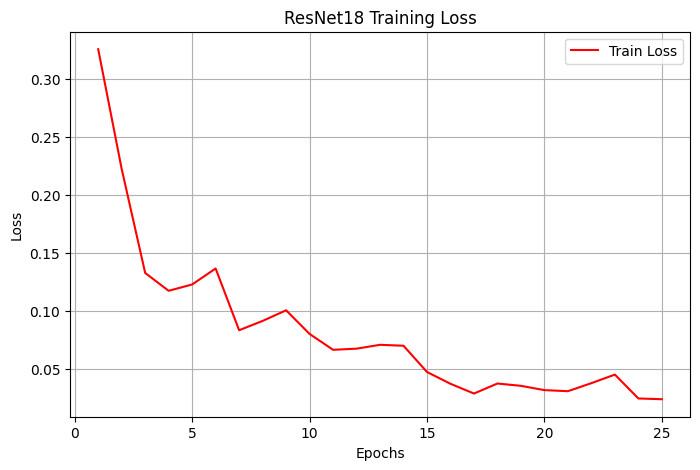

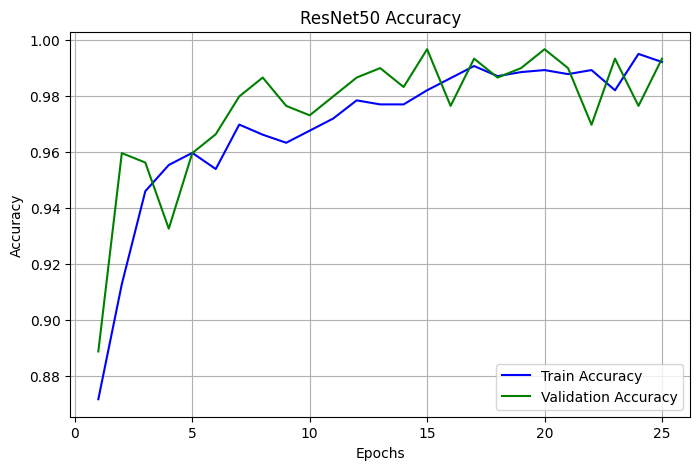

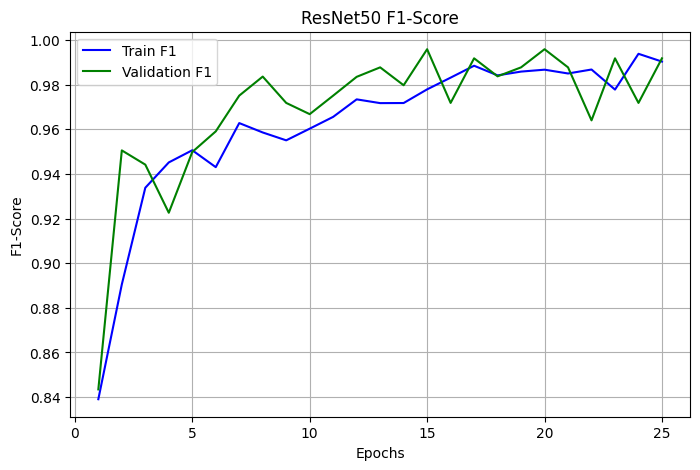

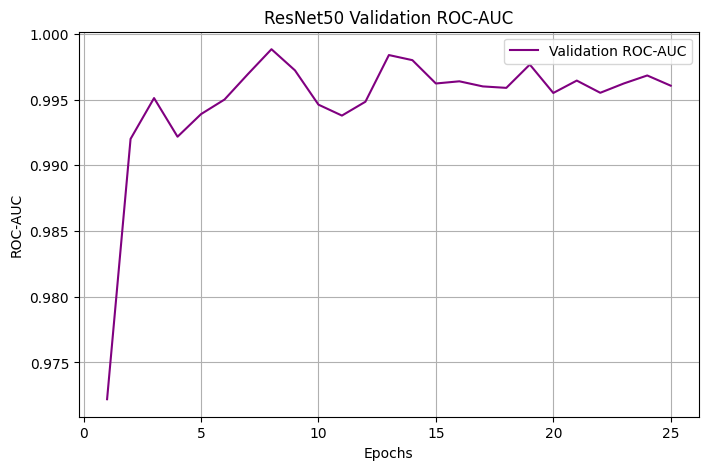

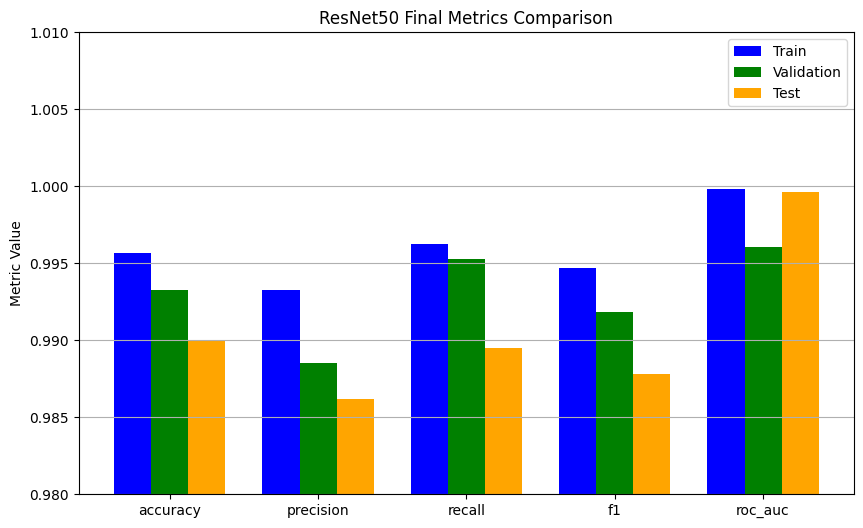

In [26]:
import json
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# Load JSON file with outputs
# -----------------------------
with open('/kaggle/working/outputs/resnet50_results_20251030_113902.json', 'r') as f:
    data = json.load(f)

history = data['history']

# Extract metrics
train_loss = history['train_loss']
train_acc = history['train_acc']
train_f1 = history['train_f1']

val_acc = history['val_acc']
val_f1 = history['val_f1']
val_roc_auc = [m['roc_auc'] for m in history['val_metrics']]

epochs = list(range(1, len(train_loss) + 1))

# -----------------------------
# Plot Loss
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, label='Train Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ResNet18 Training Loss')
plt.grid(True)
plt.legend()
plt.show()
# -----------------------------
# Plot Accuracy
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(epochs, train_acc, label='Train Accuracy', color='blue')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ResNet50 Accuracy')
plt.grid(True)
plt.legend()
plt.show()

# -----------------------------
# Plot F1-Score
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(epochs, train_f1, label='Train F1', color='blue')
plt.plot(epochs, val_f1, label='Validation F1', color='green')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.title('ResNet50 F1-Score')
plt.grid(True)
plt.legend()
plt.show()

# -----------------------------
# Plot ROC-AUC
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(epochs, val_roc_auc, label='Validation ROC-AUC', color='purple')
plt.xlabel('Epochs')
plt.ylabel('ROC-AUC')
plt.title('ResNet50 Validation ROC-AUC')
plt.grid(True)
plt.legend()
plt.show()
# -----------------------------
# Final Metrics Comparison (Train, Validation, Test)
# -----------------------------
metrics_train = data['metrics_train']
metrics_val = data['metrics_val']
metrics_test = data['metrics_test']

metric_names = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

train_values = [metrics_train[m] for m in metric_names]
val_values = [metrics_val[m] for m in metric_names]
test_values = [metrics_test[m] for m in metric_names]

x = np.arange(len(metric_names))  # the label locations
width = 0.25  # width of the bars

plt.figure(figsize=(10,6))
plt.bar(x - width, train_values, width, label='Train', color='blue')
plt.bar(x, val_values, width, label='Validation', color='green')
plt.bar(x + width, test_values, width, label='Test', color='orange')

plt.xticks(x, metric_names)
plt.ylim(0.98, 1.01)  # focus on high-performance range
plt.ylabel('Metric Value')
plt.title('ResNet50 Final Metrics Comparison')
plt.grid(axis='y')
plt.legend()
plt.show()

In [30]:
main("vgg16")


*** Running: vgg16 ***


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 141MB/s] 



=== vgg16 Epoch 1/100 ===
Train loss: 0.5125 acc: 0.7574 f1: 0.6722
Val metrics: acc 0.8586 f1 0.8218 roc_auc 0.9235849056603773
Saved best checkpoint to checkpoints/vgg16_best.pth

=== vgg16 Epoch 2/100 ===
Train loss: 0.3016 acc: 0.8683 f1: 0.8333
Val metrics: acc 0.8990 f1 0.8717 roc_auc 0.966093229744728
Saved best checkpoint to checkpoints/vgg16_best.pth

=== vgg16 Epoch 3/100 ===
Train loss: 0.3159 acc: 0.8819 f1: 0.8512
Val metrics: acc 0.8889 f1 0.8450 roc_auc 0.9593229744728079

=== vgg16 Epoch 4/100 ===
Train loss: 0.2426 acc: 0.9071 f1: 0.8844
Val metrics: acc 0.9226 f1 0.9028 roc_auc 0.9705882352941176
Saved best checkpoint to checkpoints/vgg16_best.pth

=== vgg16 Epoch 5/100 ===
Train loss: 0.1990 acc: 0.9172 f1: 0.8961
Val metrics: acc 0.9428 f1 0.9287 roc_auc 0.9841842397336293
Saved best checkpoint to checkpoints/vgg16_best.pth

=== vgg16 Epoch 6/100 ===
Train loss: 0.1933 acc: 0.9230 f1: 0.9033
Val metrics: acc 0.9293 f1 0.9132 roc_auc 0.985904550499445

=== vgg16 Epo

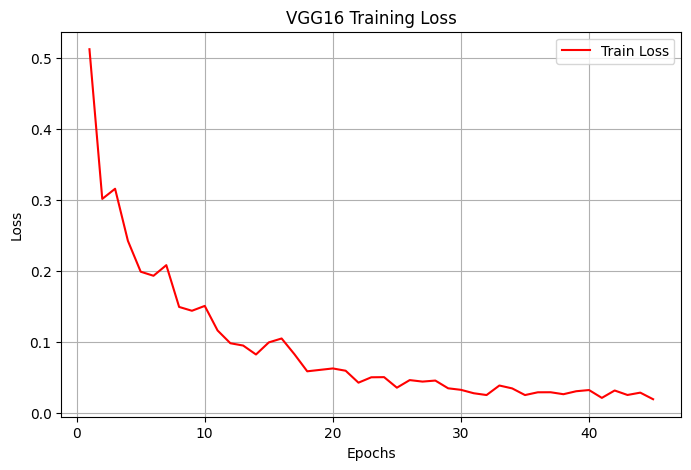

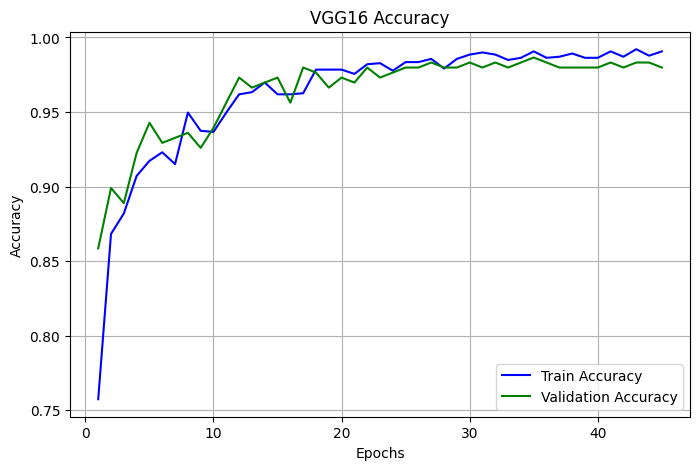

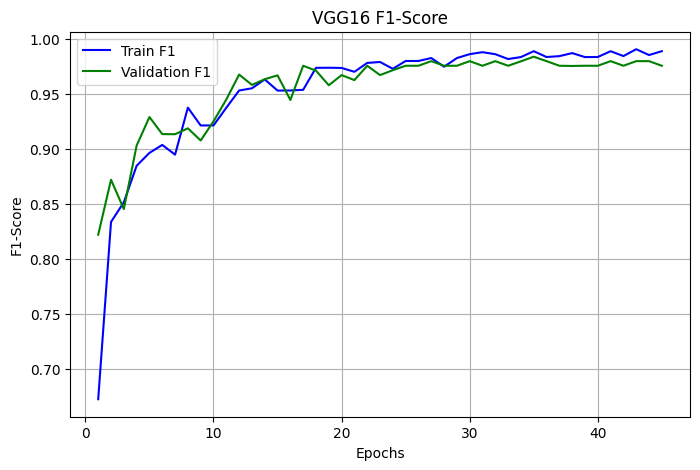

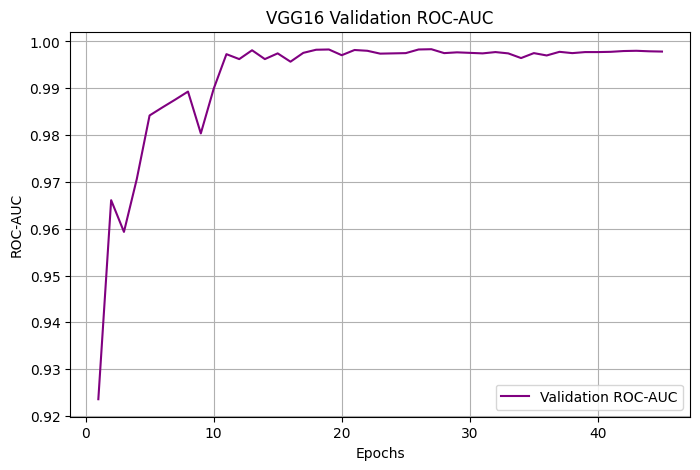

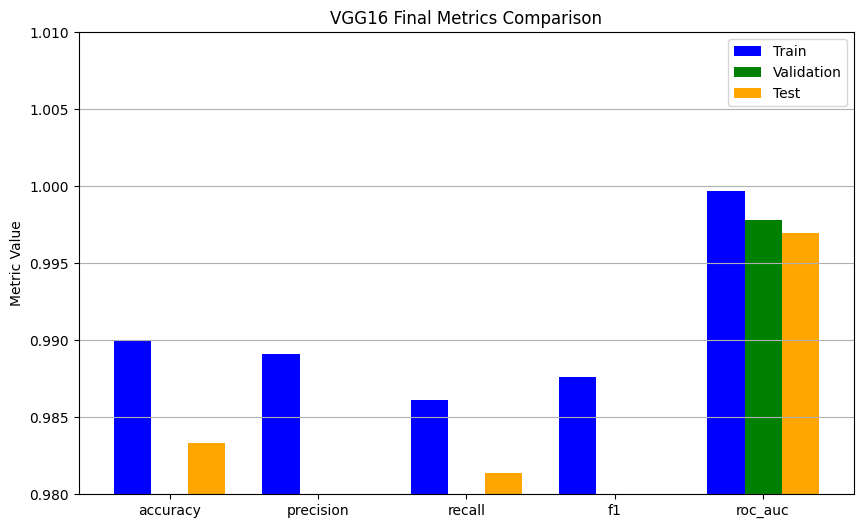

In [31]:
import json
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# Load JSON file with outputs
# -----------------------------
with open('/kaggle/working/outputs/vgg16_results_20251030_122145.json', 'r') as f:
    data = json.load(f)

history = data['history']

# Extract metrics
train_loss = history['train_loss']
train_acc = history['train_acc']
train_f1 = history['train_f1']

val_acc = history['val_acc']
val_f1 = history['val_f1']
val_roc_auc = [m['roc_auc'] for m in history['val_metrics']]

epochs = list(range(1, len(train_loss) + 1))

# -----------------------------
# Plot Loss
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, label='Train Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG16 Training Loss')
plt.grid(True)
plt.legend()
plt.show()
# -----------------------------
# Plot Accuracy
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(epochs, train_acc, label='Train Accuracy', color='blue')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('VGG16 Accuracy')
plt.grid(True)
plt.legend()
plt.show()

# -----------------------------
# Plot F1-Score
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(epochs, train_f1, label='Train F1', color='blue')
plt.plot(epochs, val_f1, label='Validation F1', color='green')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.title('VGG16 F1-Score')
plt.grid(True)
plt.legend()
plt.show()

# -----------------------------
# Plot ROC-AUC
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(epochs, val_roc_auc, label='Validation ROC-AUC', color='purple')
plt.xlabel('Epochs')
plt.ylabel('ROC-AUC')
plt.title('VGG16 Validation ROC-AUC')
plt.grid(True)
plt.legend()
plt.show()
# -----------------------------
# Final Metrics Comparison (Train, Validation, Test)
# -----------------------------
metrics_train = data['metrics_train']
metrics_val = data['metrics_val']
metrics_test = data['metrics_test']

metric_names = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

train_values = [metrics_train[m] for m in metric_names]
val_values = [metrics_val[m] for m in metric_names]
test_values = [metrics_test[m] for m in metric_names]

x = np.arange(len(metric_names))  # the label locations
width = 0.25  # width of the bars

plt.figure(figsize=(10,6))
plt.bar(x - width, train_values, width, label='Train', color='blue')
plt.bar(x, val_values, width, label='Validation', color='green')
plt.bar(x + width, test_values, width, label='Test', color='orange')

plt.xticks(x, metric_names)
plt.ylim(0.98, 1.01)  # focus on high-performance range
plt.ylabel('Metric Value')
plt.title('VGG16 Final Metrics Comparison')
plt.grid(axis='y')
plt.legend()
plt.show()